In [2]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Veri setlerini yükleyelim
authors_df = pd.read_csv('authors.csv')
books_df = pd.read_csv('book_rating.csv')

# Veriye ilk bakış
print("Yazarlar Verisi:")
display(authors_df.head(2))
print("\nKitaplar Verisi:")
display(books_df.head(2))

FileNotFoundError: [Errno 2] No such file or directory: 'authors.csv'

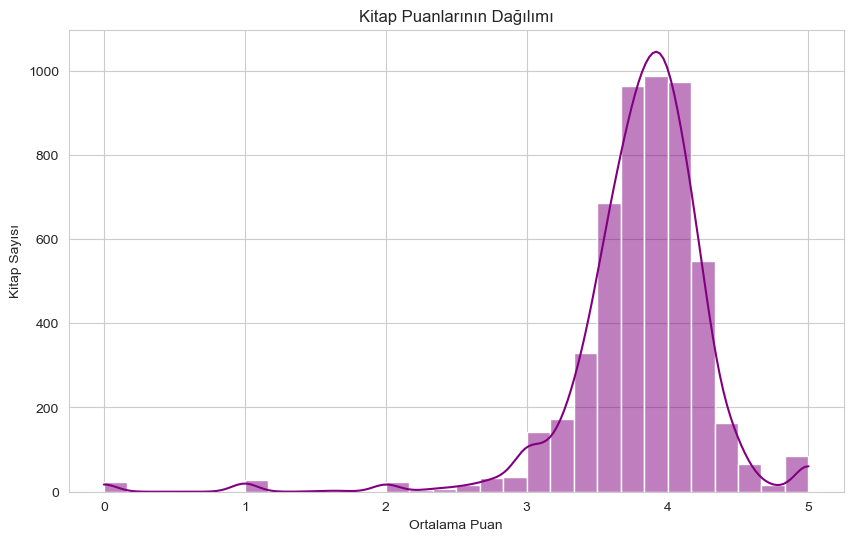

C:\Users\ilydo\AppData\Local\Temp\ipykernel_28208\1768113785.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vote_count', y='name', data=top_voted, palette='viridis')


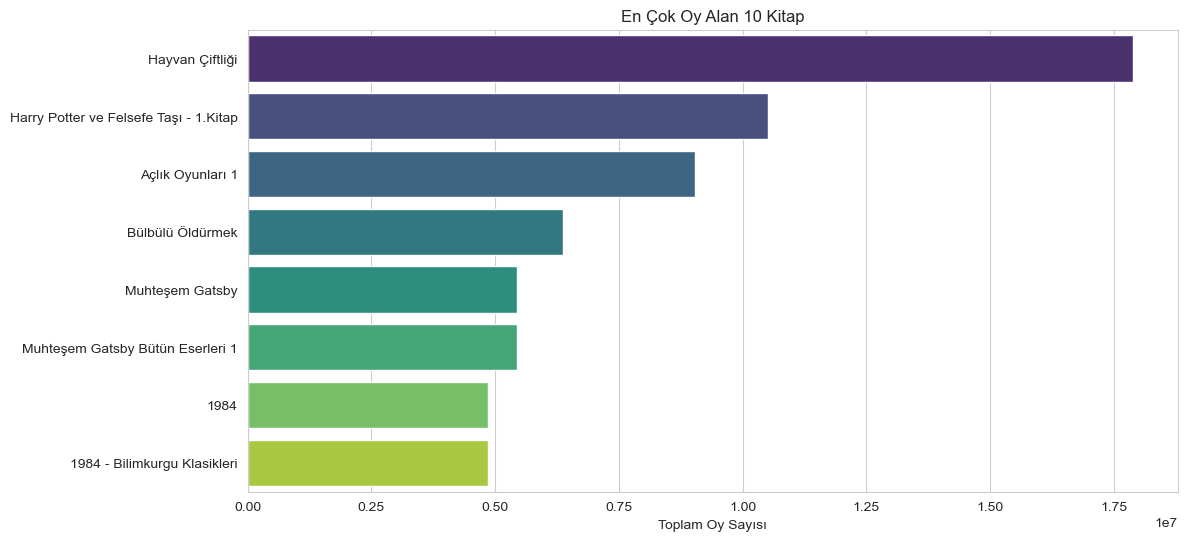

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirme ayarları
sns.set_style("whitegrid")

# 1. Puan Dağılımı Grafiği: Kitaplara genellikle kaç puan verilmiş?
plt.figure(figsize=(10, 6))
sns.histplot(books_df['average_rating'], bins=30, kde=True, color='purple')
plt.title('Kitap Puanlarının Dağılımı')
plt.xlabel('Ortalama Puan')
plt.ylabel('Kitap Sayısı')
plt.show()

# Yorum: "Grafikte görüldüğü üzere, okuyucular genellikle cömert davranıp 3.5 - 4.5 arası puanlar vermişler."

# 2. En Çok Oy Alan 10 Kitap Grafiği
# Önce vote_count hesaplanmış olmalı (Önceki cevaptaki temizlik kodunu çalıştırdıktan sonra bu grafiği çizin)
top_voted = books_df.sort_values('vote_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='vote_count', y='name', data=top_voted, palette='viridis')
plt.title('En Çok Oy Alan 10 Kitap')
plt.xlabel('Toplam Oy Sayısı')
plt.ylabel(None)
plt.show()

In [ ]:
# 1. Kitap Verisi Temizliği
# Yıldız sayılarını (NaN varsa 0 ile doldurup) toplayarak toplam oy sayısını bulalım
vote_cols = ['one_star_count', 'two_star_count', 'three_star_count', 'four_star_count', 'five_star_count']
books_df[vote_cols] = books_df[vote_cols].fillna(0)

# Toplam oy sayısı sütunu oluşturma
books_df['vote_count'] = books_df[vote_cols].sum(axis=1)

# Hatalı verileri temizleme (Puanı 5'ten büyük olanları çıkaralım)
books_df = books_df[books_df['average_rating'] <= 5]

# Hiç oy almamış kitapları filtreleyelim
books_df = books_df[books_df['vote_count'] > 0]

print(f"Temizlik sonrası kitap sayısı: {len(books_df)}")

Temizlik sonrası kitap sayısı: 5307


In [ ]:
# C: Tüm kitapların ortalama puanı
C = books_df['average_rating'].mean()

# m: Listeye girmek için gereken minimum oy (En çok oy alan %10'luk dilim)
m = books_df['vote_count'].quantile(0.90)

print(f"Genel Ortalama (C): {C:.2f}")
print(f"Minimum Oy Eşiği (m): {m:.2f}")

# Fonksiyon: Ağırlıklı Puanı Hesapla
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(v+m) * C)

# Öneri listesini oluştur
recommended_books = books_df.copy().loc[books_df['vote_count'] >= m]
recommended_books['score'] = recommended_books.apply(weighted_rating, axis=1)

# Skora göre sırala
recommended_books = recommended_books.sort_values('score', ascending=False)

# En iyi 10 Kitabı Göster
print("\n--- En İyi 10 Kitap Önerisi (Popülerlik ve Kalite Bazlı) ---")
display(recommended_books[['name', 'vote_count', 'average_rating', 'score']].head(10))

Genel Ortalama (C): 3.81
Minimum Oy Eşiği (m): 128863.00

--- En İyi 10 Kitap Önerisi (Popülerlik ve Kalite Bazlı) ---


,name,vote_count,average_rating,score
914,Sis ve Öfke Sarayı,2433666.0,4.65,4.607663
810,Harry Potter ve Ölüm Yadigarları - 7. Kitap,3849073.0,4.62,4.593699
772,Harry Potter ve Azkaban Tutsağı - 3.kitap,4408537.0,4.58,4.558078
855,Harry Potter ve Melez Prens - 6. Kitap,3408430.0,4.58,4.551880
873,Harry Potter ve Ateş Kadehi - 4.kitap,3867322.0,4.57,4.545431
977,Harry Potter ve Zümrüdüanka Yoldaşlığı - 5.kitap,3522216.0,4.50,4.475580
843,Sahte Krallık,687816.0,4.59,4.466625
580,Harry Potter ve Felsefe Taşı - 1.Kitap,10506702.0,4.47,4.461980
1656,Josh ve Hazel'ın Sevgili Olmama Rehberi,167598.0,4.94,4.447995
975,Kargaların Ziyafeti Kısım 1,808076.0,4.54,4.439337


In [ ]:
# Biyografisi boş olanları doldur
authors_df['biography'] = authors_df['biography'].fillna('')

# TF-IDF Vektörleştiriciyi tanımla (İngilizce stop words kullanıyoruz, Türkçe için özel liste eklenebilir)
tfidf = TfidfVectorizer(stop_words='english')

# Biyografileri matrise çevir
tfidf_matrix = tfidf.fit_transform(authors_df['biography'])

# Cosine Similarity (Benzerlik) Matrisini hesapla
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Yazar isminden indekse ulaşmak için bir harita (mapping) oluştur
indices = pd.Series(authors_df.index, index=authors_df['name']).drop_duplicates()

# Öneri Fonksiyonu
def get_author_recommendations(name, cosine_sim=cosine_sim):
    # İsmi kontrol et
    if name not in indices:
        return "Bu isimde bir yazar bulunamadı."
    
    # Yazarın indeksini al
    idx = indices[name]
    
    # Tüm yazarlarla olan benzerlik skorlarını al
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Skorlara göre sırala (En çok benzeyenden en aza)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Kendisi hariç en benzer 10 yazarı al
    sim_scores = sim_scores[1:11]
    
    # İndeksleri al
    author_indices = [i[0] for i in sim_scores]
    
    # İsimleri döndür
    return authors_df['name'].iloc[author_indices]

In [ ]:
# Test: Edmund Crispin (Polisiye/Gizem yazarı)
author_name = "Edmund Crispin"

print(f"--- '{author_name}' sevenler için yazar önerileri ---")
recommendations = get_author_recommendations(author_name)
print(recommendations)

--- 'Edmund Crispin' sevenler için yazar önerileri ---
1339           Petros Markaris
2525               M. R. James
9              Henning Mankell
1138           Lloyd Alexander
637     Alexander McCall Smith
2450              Rick Gekoski
2574               Fred Vargas
18            William Beckford
3157        Giovanni Boccaccio
2824                  L. James
Name: name, dtype: object


In [ ]:
def yazar_bulucu(aranan_isim, tum_yazarlar):
    """
    Kullanıcının girdiği ismi veri setinde arar.
    Tam eşleşme yoksa, içinde geçen (partial match) ilk ismi döndürür.
    Örn: 'Rowling' yazarsa 'J.K. Rowling' bulur.
    """
    # 1. Tam Eşleşme Kontrolü
    if aranan_isim in tum_yazarlar:
        return aranan_isim
    
    # 2. Benzerlik Kontrolü (Büyük/küçük harf duyarsız)
    for mevcut_isim in tum_yazarlar:
        if aranan_isim.lower() in mevcut_isim.lower():
            return mevcut_isim
            
    return None

def proje_demo_final():
    print("\n" + "="*60)
    print("📚  AKILLI KİTAP VE YAZAR ÖNERİ SİSTEMİNE HOŞ GELDİNİZ  📚")
    print("="*60)
    
    # Yazarların listesini indeks yapımızdan alalım
    tum_yazarlar = indices.index.tolist()
    
    while True:
        print("\n--- MENÜ ---")
        print("1. 🏆  Tüm Zamanların En Popüler Kitaplarını Listele")
        print("2. ✍️   Yazar Adı ile 'Benzer Kitaplara Sahip' Yazarları Bul")
        print("3. ❌  Çıkış")
        
        secim = input("👉 Seçiminiz (1-3): ")
        
        if secim == '1':
            print("\n" + "-"*30)
            print("🌟 EN ÇOK SEVİLEN VE OY ALAN KİTAPLAR 🌟")
            print("-"*30)
            # Daha önce hesapladığımız 'score' sütununa göre
            cols = ['name', 'average_rating', 'vote_count']
            top_list = recommended_books[cols].head(10)
            
            # Tabloyu daha şık basalım
            for i, row in top_list.reset_index().iterrows():
                print(f"{i+1}. {row['name']} (Puan: {row['average_rating']} | Oy: {int(row['vote_count'])})")
                
        elif secim == '2':
            print("\n" + "-"*50)
            print("🔎 YAZAR VE KİTAP TARZI ANALİZİ")
            print("-"*50)
            girilen_isim = input("Hangi yazarın kitaplarını seviyorsunuz? (Örn: J.K. Rowling): ")
            
            # Akıllı isim bulma (Fuzzy Search)
            bulunan_yazar = yazar_bulucu(girilen_isim, tum_yazarlar)
            
            if bulunan_yazar:
                print(f"\n✅ Algılanan Yazar: '{bulunan_yazar}'")
                print(f"🔄 '{bulunan_yazar}' tarzında yazan ve benzer kitaplara sahip yazarlar aranıyor...\n")
                
                try:
                    oneriler = get_author_recommendations(bulunan_yazar)
                    
                    print(f"📢 '{bulunan_yazar}' sevenlere özel yazar önerileri:")
                    for i, yazar in enumerate(oneriler, 1):
                        print(f"   {i}. {yazar}")
                        
                    print("\n💡 Bilgi: Bu öneriler, yazarların biyografik içerik, tür ve üslup benzerliklerine göre hazırlanmıştır.")
                except Exception as e:
                    print("⚠️ Bir hata oluştu:", e)
            else:
                print(f"❌ '{girilen_isim}' adında bir yazar veri tabanımızda bulunamadı.")
                
        elif secim == '3':
            print("\n👋 Sistemden çıkılıyor. İyi okumalar!")
            break
        else:
            print("⚠️ Lütfen geçerli bir seçim yapınız (1, 2 veya 3).")

# Uygulamayı Başlat
proje_demo_final()


📚  AKILLI KİTAP VE YAZAR ÖNERİ SİSTEMİNE HOŞ GELDİNİZ  📚

--- MENÜ ---
1. 🏆  Tüm Zamanların En Popüler Kitaplarını Listele
2. ✍️   Yazar Adı ile 'Benzer Kitaplara Sahip' Yazarları Bul
3. ❌  Çıkış


👉 Seçiminiz (1-3):  1



------------------------------
🌟 EN ÇOK SEVİLEN VE OY ALAN KİTAPLAR 🌟
------------------------------
1. Sis ve Öfke Sarayı (Puan: 4.65 | Oy: 2433666)
2. Harry Potter ve Ölüm Yadigarları - 7. Kitap (Puan: 4.62 | Oy: 3849073)
3. Harry Potter ve Azkaban Tutsağı - 3.kitap (Puan: 4.58 | Oy: 4408537)
4. Harry Potter ve Melez Prens - 6. Kitap (Puan: 4.58 | Oy: 3408430)
5. Harry Potter ve Ateş Kadehi - 4.kitap (Puan: 4.57 | Oy: 3867322)
6. Harry Potter ve Zümrüdüanka Yoldaşlığı - 5.kitap (Puan: 4.5 | Oy: 3522216)
7. Sahte Krallık (Puan: 4.59 | Oy: 687816)
8. Harry Potter ve Felsefe Taşı - 1.Kitap (Puan: 4.47 | Oy: 10506702)
9. Josh ve Hazel'ın Sevgili Olmama Rehberi (Puan: 4.94 | Oy: 167598)
10. Kargaların Ziyafeti Kısım 1 (Puan: 4.54 | Oy: 808076)

--- MENÜ ---
1. 🏆  Tüm Zamanların En Popüler Kitaplarını Listele
2. ✍️   Yazar Adı ile 'Benzer Kitaplara Sahip' Yazarları Bul
3. ❌  Çıkış


👉 Seçiminiz (1-3):  2



--------------------------------------------------
🔎 YAZAR VE KİTAP TARZI ANALİZİ
--------------------------------------------------


Hangi yazarın kitaplarını seviyorsunuz? (Örn: J.K. Rowling):  Neil Gaiman



✅ Algılanan Yazar: 'Neil Gaiman'
🔄 'Neil Gaiman' tarzında yazan ve benzer kitaplara sahip yazarlar aranıyor...

📢 'Neil Gaiman' sevenlere özel yazar önerileri:
   1. Anna Todd
   2. Daphne Du Maurier
   3. Richard Matheson
   4. David Peace
   5. Jessica Khoury
   6. M. R. James
   7. Robert Jackson Bennett
   8. Charles Beaumont
   9. Douglas Adams
   10. Nicholas Sparks

💡 Bilgi: Bu öneriler, yazarların biyografik içerik, tür ve üslup benzerliklerine göre hazırlanmıştır.

--- MENÜ ---
1. 🏆  Tüm Zamanların En Popüler Kitaplarını Listele
2. ✍️   Yazar Adı ile 'Benzer Kitaplara Sahip' Yazarları Bul
3. ❌  Çıkış


👉 Seçiminiz (1-3):  3



👋 Sistemden çıkılıyor. İyi okumalar!
